# Analysis

Fast notebook with some tables and plots to understand better how the algorithm
behaves on different datasets and with different parallel backends.

In [ ]:
import pandas as pd

df = pd.read_csv("../results/cluster_breast_cancer_4.csv")
df

,estimators,max_depth,backend,threads,nodes,train_accuracy,train_f1,test_accuracy,test_f1,train_time,train_predict_time,test_predict_time
0,32,0,ff,1,1,1.0,1.0,0.964602,0.958608,152.64070,1.000058,0.551102
1,32,0,ff,2,1,1.0,1.0,0.964602,0.958608,83.29171,0.871347,0.628523
2,32,0,ff,4,1,1.0,1.0,0.964602,0.958608,44.56570,1.084550,0.903558
3,32,0,ff,8,1,1.0,1.0,0.964602,0.958608,28.07265,2.116886,2.249374
4,32,0,ff,16,1,1.0,1.0,0.964602,0.958608,16.06109,4.761930,4.413142
...,...,...,...,...,...,...,...,...,...,...,...,...
61,128,0,omp,4,1,1.0,1.0,0.964602,0.958608,161.32930,0.535433,0.167268
62,128,0,omp,8,1,1.0,1.0,0.964602,0.958608,85.29928,0.337354,0.126531
63,128,0,omp,16,1,1.0,1.0,0.964602,0.958608,45.42494,0.288595,0.107450
64,128,0,omp,32,1,1.0,1.0,0.964602,0.958608,33.89609,0.300351,0.132276


In [4]:
seq = df[df["backend"] == "seq"]

keys = ["estimators", "max_depth"]
merged = seq.merge(df, how="right", on=keys, suffixes=("_seq", "_mt"))

df["train_speedup"] = merged["train_time_seq"] / merged["train_time_mt"]
df["train_efficiency"] = df["train_speedup"] / merged["threads_mt"]

df

,estimators,max_depth,backend,threads,nodes,train_accuracy,train_f1,test_accuracy,test_f1,train_time,train_predict_time,test_predict_time,train_speedup,train_efficiency
0,32,0,ff,1,1,1.0,1.0,0.964602,0.958608,152.64070,1.000058,0.551102,0.991321,0.991321
1,32,0,ff,2,1,1.0,1.0,0.964602,0.958608,83.29171,0.871347,0.628523,1.816698,0.908349
2,32,0,ff,4,1,1.0,1.0,0.964602,0.958608,44.56570,1.084550,0.903558,3.395344,0.848836
3,32,0,ff,8,1,1.0,1.0,0.964602,0.958608,28.07265,2.116886,2.249374,5.390154,0.673769
4,32,0,ff,16,1,1.0,1.0,0.964602,0.958608,16.06109,4.761930,4.413142,9.421272,0.588830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,128,0,omp,4,1,1.0,1.0,0.964602,0.958608,161.32930,0.535433,0.167268,3.698382,0.924596
62,128,0,omp,8,1,1.0,1.0,0.964602,0.958608,85.29928,0.337354,0.126531,6.994870,0.874359
63,128,0,omp,16,1,1.0,1.0,0.964602,0.958608,45.42494,0.288595,0.107450,13.135018,0.820939
64,128,0,omp,32,1,1.0,1.0,0.964602,0.958608,33.89609,0.300351,0.132276,17.602544,0.550079


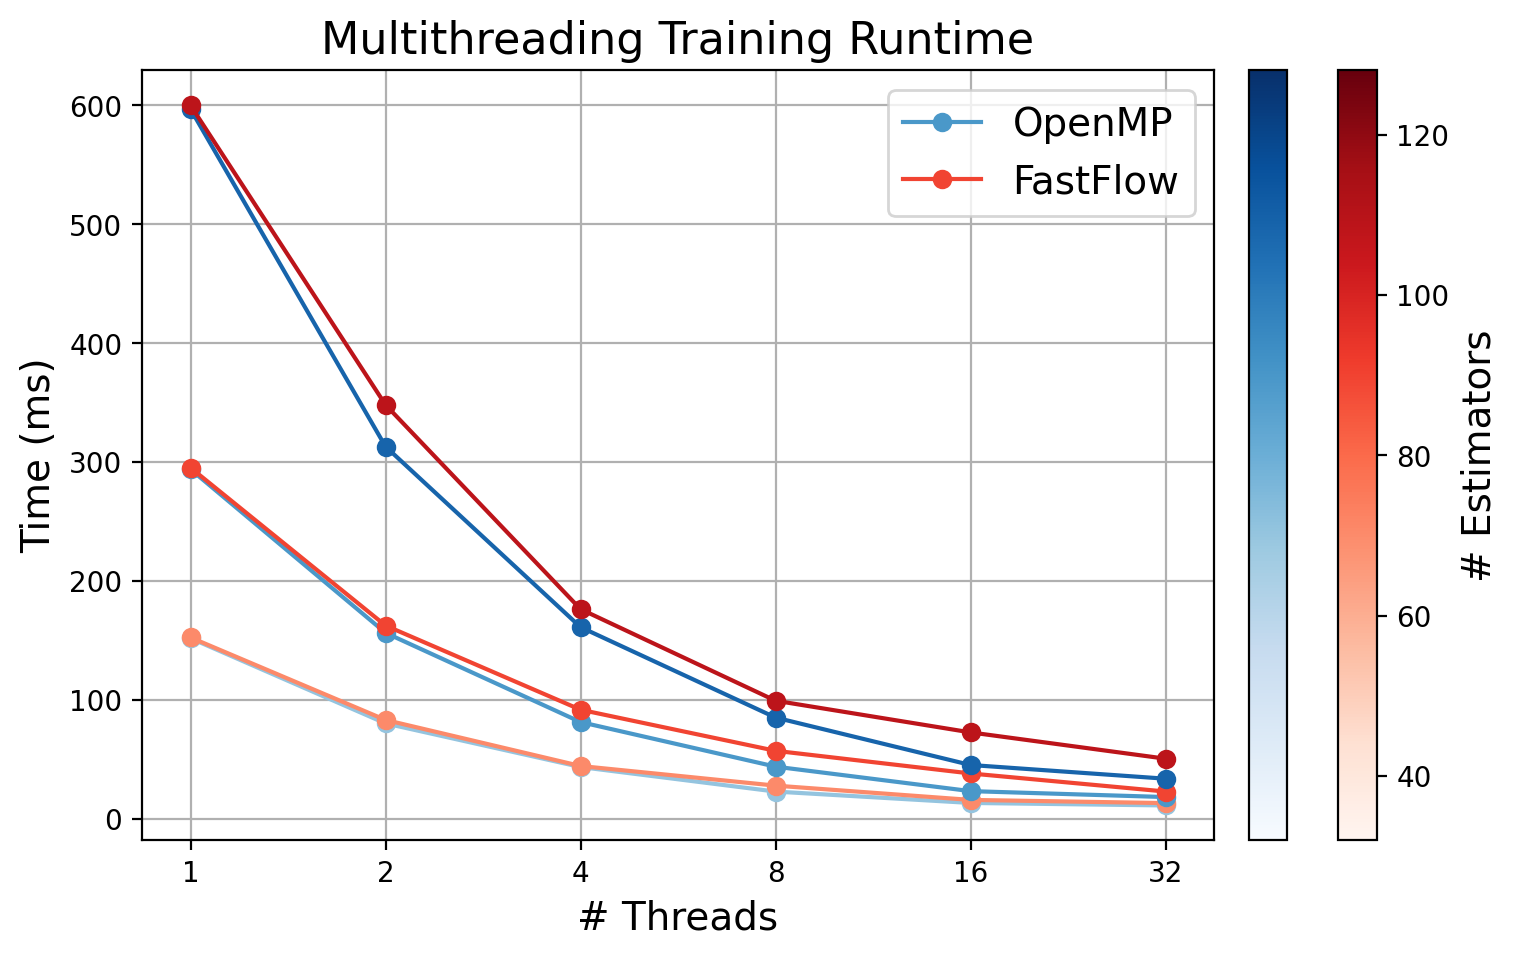

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

omp = df[df["backend"] == "omp"]
ff  = df[df["backend"] == "ff"]

estimators = np.sort(df["estimators"].unique())

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
ax.set_title("Multithreading Training Runtime", fontsize=16)

blues = plt.cm.Blues(np.linspace(0.4, 0.8, len(estimators)))
reds  = plt.cm.Reds (np.linspace(0.4, 0.8, len(estimators)))

for i, e in enumerate(estimators):
    omp_e = omp[omp["estimators"] == e]
    ff_e  = ff [ff ["estimators"] == e]

    ax.plot(
        omp_e["threads"], omp_e["train_time"],
        marker="o", color=blues[i]
    )

    ax.plot(
        ff_e["threads"], ff_e["train_time"],
        marker="o", color=reds[i]
    )

# ----- COLORBAR -----
norm = Normalize(vmin=estimators.min(), vmax=estimators.max())

sm_omp = ScalarMappable(norm=norm, cmap=plt.cm.Blues)
sm_omp.set_array([])

sm_ff = ScalarMappable(norm=norm, cmap=plt.cm.Reds)
sm_ff.set_array([])

cbar_ff = fig.colorbar(sm_ff, ax=ax, fraction=0.035, pad=0.04)
cbar_ff.set_label(r"# Estimators", fontsize=14)
# cbar_ff.set_ticks([])

cbar_omp = fig.colorbar(sm_omp, ax=ax, fraction=0.035, pad=0.03)
cbar_omp.set_ticks([])

# ----- AXES -----
ax.set_xscale("log", base=2)
ticks = df["threads"].unique()
ax.set_xticks(ticks)
ax.set_xticklabels([str(t) for t in ticks])

ax.set_xlabel("# Threads", fontsize=14)
ax.set_ylabel("Time (ms)", fontsize=14)
ax.grid()

omp_handle = plt.Line2D([], [], color=blues[1], marker='o', label='OpenMP')
ff_handle  = plt.Line2D([], [], color=reds[1], marker='o', label='FastFlow')
ax.legend(handles=[omp_handle, ff_handle], fontsize=14)

plt.show()

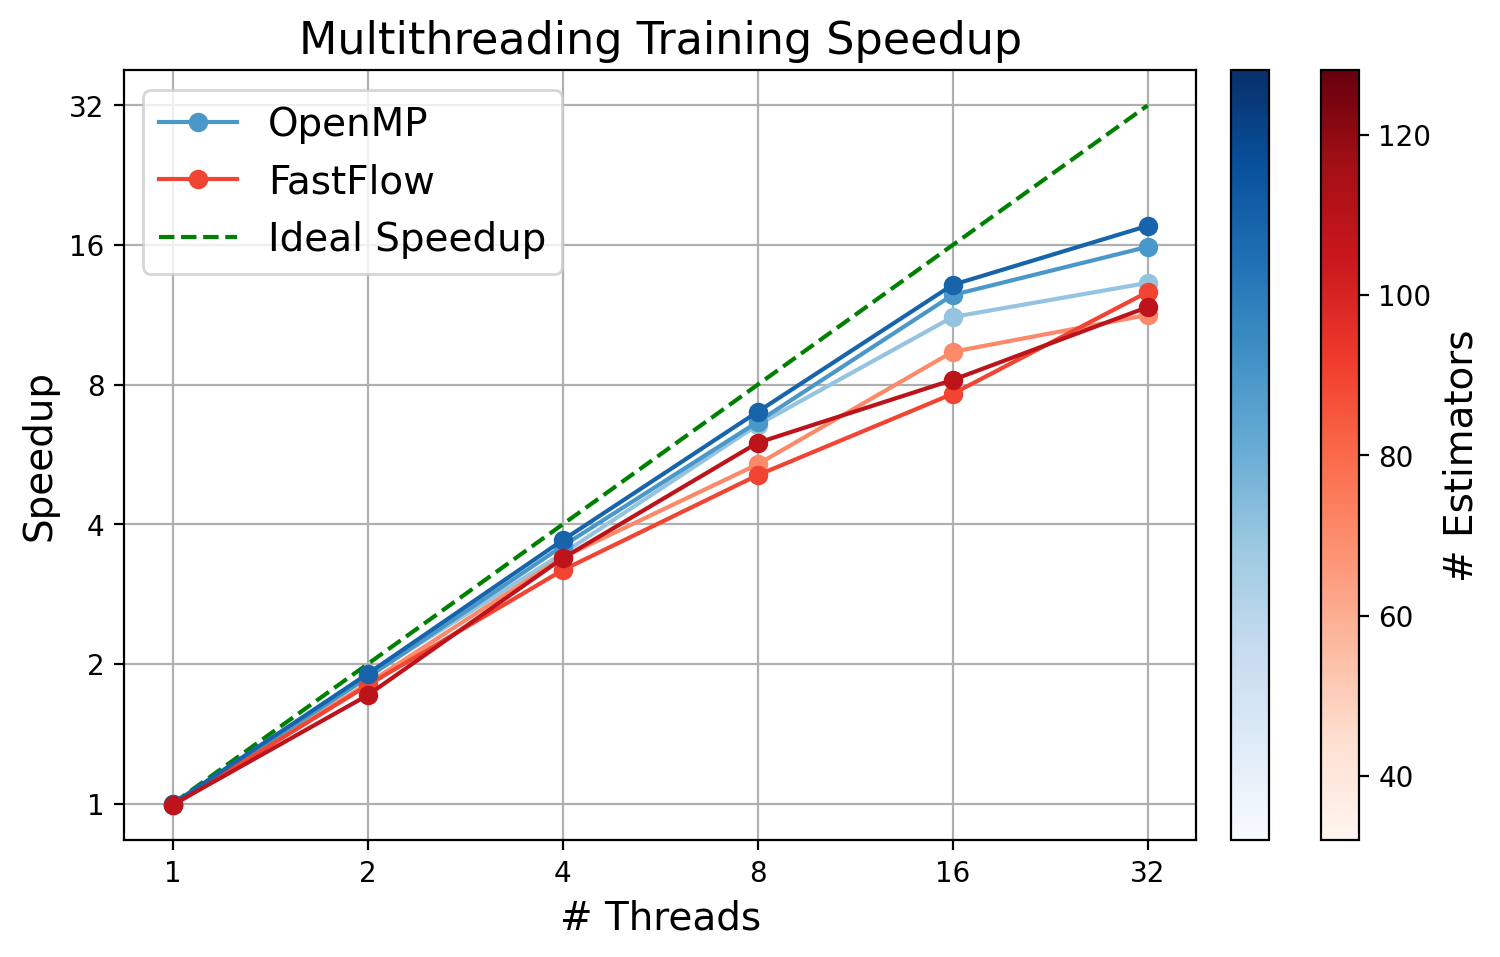

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

omp = df[df["backend"] == "omp"]
ff  = df[df["backend"] == "ff"]

estimators = np.sort(df["estimators"].unique())

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
ax.set_title("Multithreading Training Speedup", fontsize=16)

blues = plt.cm.Blues(np.linspace(0.4, 0.8, len(estimators)))
reds  = plt.cm.Reds (np.linspace(0.4, 0.8, len(estimators)))

ax.plot([1, 32], [1, 32], "g--")

for i, e in enumerate(estimators):
    omp_e = omp[omp["estimators"] == e]
    ff_e  = ff [ff ["estimators"] == e]

    ax.plot(
        omp_e["threads"], omp_e["train_speedup"],
        marker="o", color=blues[i]
    )

    ax.plot(
        ff_e["threads"], ff_e["train_speedup"],
        marker="o", color=reds[i]
    )

# ----- COLORBAR -----
norm = Normalize(vmin=estimators.min(), vmax=estimators.max())

sm_omp = ScalarMappable(norm=norm, cmap=plt.cm.Blues)
sm_omp.set_array([])

sm_ff = ScalarMappable(norm=norm, cmap=plt.cm.Reds)
sm_ff.set_array([])

cbar_ff = fig.colorbar(sm_ff, ax=ax, fraction=0.035, pad=0.04)
cbar_ff.set_label(r"# Estimators", fontsize=14)
# cbar_ff.set_ticks([])

cbar_omp = fig.colorbar(sm_omp, ax=ax, fraction=0.035, pad=0.03)
cbar_omp.set_ticks([])

# ----- AXES -----
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ticks = df["threads"].unique()
ax.set_xticks(ticks)
ax.set_xticklabels([str(t) for t in ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([str(t) for t in ticks])

ax.set_xlabel("# Threads", fontsize=14)
ax.set_ylabel("Speedup", fontsize=14)
ax.grid()

omp_handle = plt.Line2D([], [], color=blues[1], marker='o', label='OpenMP')
ff_handle  = plt.Line2D([], [], color=reds[1], marker='o', label='FastFlow')
ideal_handle  = plt.Line2D([], [], color="green", linestyle='--', label='Ideal Speedup')
ax.legend(handles=[omp_handle, ff_handle, ideal_handle], fontsize=14)

plt.show()

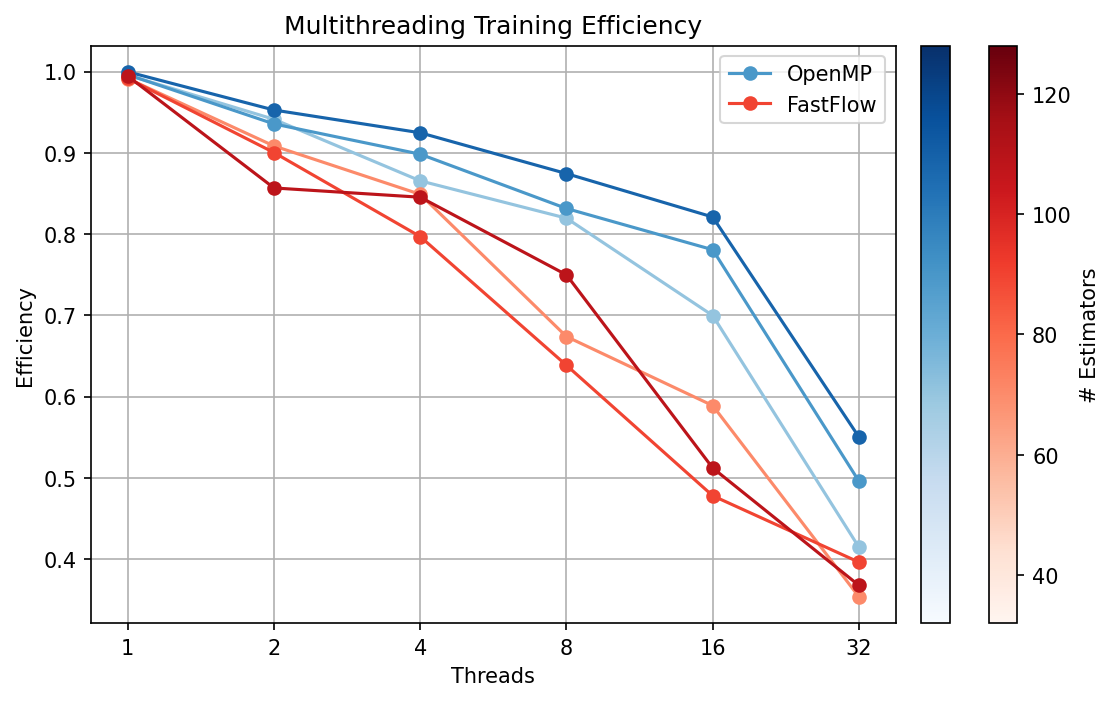

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

omp = df[df["backend"] == "omp"]
ff  = df[df["backend"] == "ff"]

estimators = np.sort(df["estimators"].unique())

fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
ax.set_title("Multithreading Training Efficiency")

blues = plt.cm.Blues(np.linspace(0.4, 0.8, len(estimators)))
reds  = plt.cm.Reds (np.linspace(0.4, 0.8, len(estimators)))

for i, e in enumerate(estimators):
    omp_e = omp[omp["estimators"] == e]
    ff_e  = ff [ff ["estimators"] == e]

    ax.plot(
        omp_e["threads"], omp_e["train_efficiency"],
        marker="o", color=blues[i]
    )

    ax.plot(
        ff_e["threads"], ff_e["train_efficiency"],
        marker="o", color=reds[i]
    )

# ----- COLORBAR -----
norm = Normalize(vmin=estimators.min(), vmax=estimators.max())

sm_omp = ScalarMappable(norm=norm, cmap=plt.cm.Blues)
sm_omp.set_array([])

sm_ff = ScalarMappable(norm=norm, cmap=plt.cm.Reds)
sm_ff.set_array([])

cbar_ff = fig.colorbar(sm_ff, ax=ax, fraction=0.035, pad=0.04)
cbar_ff.set_label(r"# Estimators")
# cbar_ff.set_ticks([])

cbar_omp = fig.colorbar(sm_omp, ax=ax, fraction=0.035, pad=0.03)
cbar_omp.set_ticks([])

# ----- AXES -----
ax.set_xscale("log", base=2)
ticks = df["threads"].unique()
ax.set_xticks(ticks)
ax.set_xticklabels([str(t) for t in ticks])

ax.set_xlabel("Threads")
ax.set_ylabel("Efficiency")
ax.grid()

omp_handle = plt.Line2D([], [], color=blues[1], marker='o', label='OpenMP')
ff_handle  = plt.Line2D([], [], color=reds[1], marker='o', label='FastFlow')
ax.legend(handles=[omp_handle, ff_handle])

plt.show()